# Image captioning using keras - Preprocessing

### Import required libraries

In [1]:
import numpy as np

import cv2
from matplotlib import pyplot as plt
import tensorflow as tf

from PIL import Image
import glob

import spacy

### Import and process input data

We will be using [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) for feature extraction. Hence the input image should be of the shape 224 x 224 x 3. <br />
Feel free to look at other pre-trained models in the [keras website](https://keras.io/api/applications/).

In [2]:
encoder_input = []

for filename in glob.glob('flickrsdataset/*.jpg'): # read every .jpg inside flickrdataset
    im=Image.open(filename)
    resized = im.resize((224,224)) # resize the image into 224 X 224 x 3
    encoder_input.append(tf.keras.preprocessing.image.img_to_array(resized)) # convert image into array and append to list

In [3]:
caps = open("tokens.txt").read() 
lines_of_data = caps.splitlines() 

captions = []
maxi = 0

for i in range(len(lines_of_data)):
    captions.append(lines_of_data[i].split('\t')[1])
    if len(captions[i]) > maxi:
        maxi = len(captions[i])
        sen = captions[i]

# So all captions will be padded with zero to the size of 'maxi'
print('Longest caption is of saze',maxi,'and is\n',sen)

Longest caption is of saze 199 and is
 An African-American man wearing a green sweatshirt and blue vest is holding up 2 dollar bills in front of his face , while standing on a busy sidewalk in front of a group of men playing instruments .


#### Create dictionaries and convert texts to number

In [4]:
word2seq = {} # word -> number
seq2word = {} # number -> word

word2seq[''] = 0
seq2word[0] = ''

word2seq['ST'] = 1 # Start Token
seq2word[1] = 'ST'

word2seq['ET'] = 2 # End Token
seq2word[2] = 'ET'

caps = []
ind = 2 # indexing start from 3, incremented later, check line 30

nlp = spacy.load('en_core_web_sm',disable=["tagger", "parser"]) # Load spacy stats model

for i in range(len(captions)):
    
    doc = nlp(captions[i])
    sent = []
    arr = np.zeros([maxi + 2]) # padding all comments with zero upto the size of avgerage
    arr[0] = 1
    
    for txt in doc:
        
        low_txt = txt.text.lower() # Convert all characters to lower case
        
        if low_txt not in word2seq:
            ind = ind + 1
            word2seq[low_txt] = ind
            seq2word[ind] = low_txt
            
        sent.append(word2seq[low_txt])
        
    arr[1:len(sent)+1] = np.stack(sent[:maxi])
    arr[len(sent)+2] = 2
    
    caps.append(arr)
    
decoder_stuff = np.stack(caps)

#### Cross verify

 total number of images : 8091 
 total number of captions : 40455 

['ST', 'a', 'man', 'in', 'an', 'orange', 'hat', 'starring', 'at', 'something', '.', '', 'ET', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


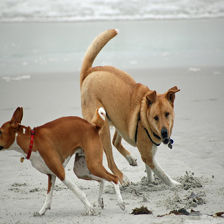

In [5]:
print(' total number of images :',len(encoder_input),'\n','total number of captions :',len(decoder_stuff),'\n')
lis = []
for i in decoder_stuff[20]:
    lis.append(seq2word[i])
print(lis)
tf.keras.preprocessing.image.array_to_img(encoder_input[20])

#### Save the dictionaries and modified data

In [6]:
# save dictionaries
np.save('word2seq.npy', word2seq) 
np.save('seq2word.npy', seq2word)

In [7]:
# save modified input data
np.save('encoder_input.npy', encoder_input)
np.save('decoder_stuff.npy', decoder_stuff)